# Project Overview: Time-series anomaly detection methods for unlabeled data

Goal:
To detect anomalies (detect occasional outliers) in network traffic

Methods:
- K-means: Control, should be flop
- DBSCAN: Better than flop k-means
- Isolation Forest Mixed results so far

Evaluation:
- Include a Correlation Matrix!
- Precision
- recall

Useful paper we steal dataset from:
- https://www.nature.com/articles/s41597-025-04603-x
- Dataset: CESNET-TimeSeries24
https://zenodo.org/records/13382427
- Details:
Use sample IP addresses cause other one is 40GB
Uses campus/institution data which would look different to datasets generated in different situations maybe?
  - unlabeled

Dataset 2: N-BaIoT
It’s a labeled Dataset with Botnet and normal traffic for IoT devices. Its files are broken up into different types of botnet attacks.
https://www.kaggle.com/datasets/mkashifn/nbaiot-dataset?select=1.gafgyt.combo.csv

- There’s a bunch of options but let’s just go with
Danmini_Doorbell (1), benign traffic, and gafgyt attack

Other Relevant research papers:
- https://www.mdpi.com/1424-8220/23/5/2844
- Anomaly Detection using Clustering:
https://www.jcbi.org/index.php/Main/article/view/598


In [1]:
import pandas as pd
import glob

path = "/Users/diandian/Desktop/course-project-cdi1diandian0309/data/CESNET_agg_10_minutes"

#files = glob.glob("/data/CESNET_agg_10_minutes/*.csv")
files = glob.glob(f"{path}/*.csv")
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [2]:
print(df.columns)
df

Index(['id_time', 'n_flows', 'n_packets', 'n_bytes', 'n_dest_asn',
       'n_dest_ports', 'n_dest_ip', 'tcp_udp_ratio_packets',
       'tcp_udp_ratio_bytes', 'dir_ratio_packets', 'dir_ratio_bytes',
       'avg_duration', 'avg_ttl'],
      dtype='object')


,id_time,n_flows,n_packets,n_bytes,n_dest_asn,n_dest_ports,n_dest_ip,tcp_udp_ratio_packets,tcp_udp_ratio_bytes,dir_ratio_packets,dir_ratio_bytes,avg_duration,avg_ttl
0,56,8,105,38628,5.0,3.0,7.0,1.00,1.00,0.59,0.35,0.33,135.62
1,57,26,911,647102,6.0,2.0,23.0,0.66,0.44,0.37,0.15,28.24,116.73
2,58,6,167,28759,4.0,2.0,6.0,1.00,1.00,0.38,0.15,90.31,108.00
3,59,12,96,22605,6.0,5.0,9.0,1.00,1.00,0.42,0.29,34.51,107.50
4,60,5,40,13655,4.0,4.0,5.0,1.00,1.00,0.90,0.99,53.65,157.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6867533,40289,4,5,308,3.0,4.0,4.0,0.60,0.45,0.20,0.27,0.00,198.75
6867534,40291,3,3,116,3.0,3.0,3.0,0.67,0.72,0.33,0.28,0.00,186.33
6867535,40295,9,10,388,5.0,5.0,7.0,0.50,0.54,0.40,0.37,0.01,140.33
6867536,40296,9,10,424,4.0,4.0,9.0,0.30,0.41,0.50,0.42,6.07,118.00


1. PRE PROCESSING FOR CSNET DATASET

In [3]:
#BASIC INFORMATION
print("\ndataset info:")
print(df.info())

#filling in any missing columns
missing_cols = df.columns[df.isnull().any()].tolist()

if missing_cols:
    for col in missing_cols:
        missing_pct = df[col].isnull().mean() * 100

        if df[col].dtype in ['float64', 'int64']: #numerical -> using median
            df[col] = df[col].fillna(df[col].median())
        else: #catergorical -> using mode
            mode_vals = df[col].mode()

            if not mode_vals.empty:
                mode_val = mode_vals[0]
                df[col] = df[col].fillna(mode_val)
            else:
                df[col] = df[col].fillna("Unknown")
else:
    print("none yippee!")

#check duplicates
duplicates = df.duplicated().sum()

if duplicates > 0:
    df = df.drop_duplicates()
    print("duplicates removed :D")

display(df.head())


dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6867538 entries, 0 to 6867537
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id_time                int64  
 1   n_flows                int64  
 2   n_packets              int64  
 3   n_bytes                int64  
 4   n_dest_asn             float64
 5   n_dest_ports           float64
 6   n_dest_ip              float64
 7   tcp_udp_ratio_packets  float64
 8   tcp_udp_ratio_bytes    float64
 9   dir_ratio_packets      float64
 10  dir_ratio_bytes        float64
 11  avg_duration           float64
 12  avg_ttl                float64
dtypes: float64(9), int64(4)
memory usage: 681.1 MB
None
none yippee!
duplicates removed :D


,id_time,n_flows,n_packets,n_bytes,n_dest_asn,n_dest_ports,n_dest_ip,tcp_udp_ratio_packets,tcp_udp_ratio_bytes,dir_ratio_packets,dir_ratio_bytes,avg_duration,avg_ttl
0,56,8,105,38628,5.0,3.0,7.0,1.00,1.00,0.59,0.35,0.33,135.62
1,57,26,911,647102,6.0,2.0,23.0,0.66,0.44,0.37,0.15,28.24,116.73
2,58,6,167,28759,4.0,2.0,6.0,1.00,1.00,0.38,0.15,90.31,108.00
3,59,12,96,22605,6.0,5.0,9.0,1.00,1.00,0.42,0.29,34.51,107.50
4,60,5,40,13655,4.0,4.0,5.0,1.00,1.00,0.90,0.99,53.65,157.60


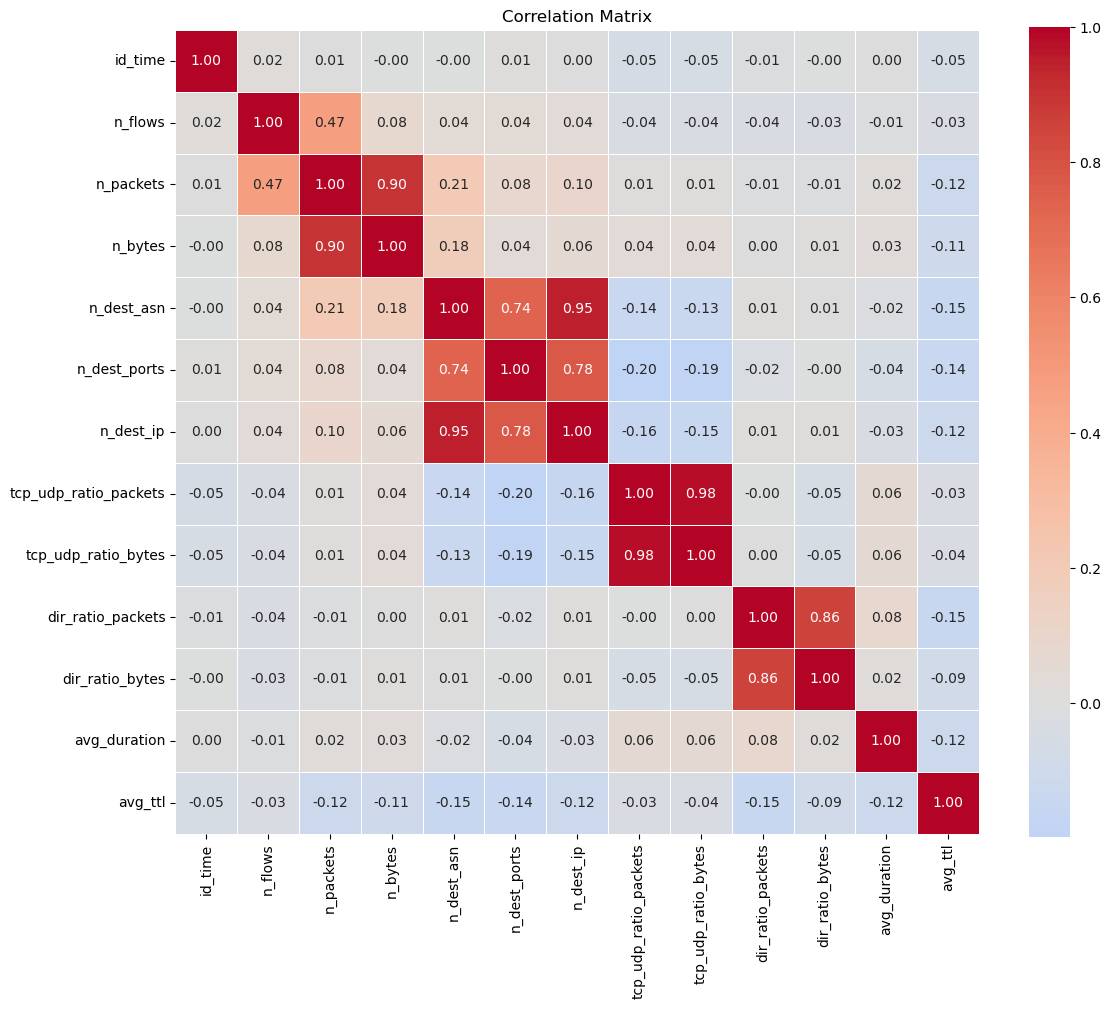


 highly correlated feature pairs:

Feature 1: n_packets, Feature 2: n_bytes, corr = 0.898084
Feature 1: n_dest_asn, Feature 2: n_dest_ip, corr = 0.951843
Feature 1: tcp_udp_ratio_packets, Feature 2: tcp_udp_ratio_bytes, corr = 0.977072
Feature 1: dir_ratio_packets, Feature 2: dir_ratio_bytes, corr = 0.859511


In [ ]:
#correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

print("\n highly correlated feature pairs:\n")
high_corr_pairs = []

corr_matrix_cols_len =len(correlation_matrix.columns)
for i in range(corr_matrix_cols_len):
    for j in range(i + 1, corr_matrix_cols_len):
        val = correlation_matrix.iloc[i, j]

        if abs(val) > 0.8:
            feature_1 = correlation_matrix.columns[i]
            feature_2 = correlation_matrix.columns[j]

            high_corr_pairs.append((feature_1, feature_2, val))
            print(f"Feature 1: {feature_1}, Feature 2: {feature_2}, corr = {val:4f}")

if not high_corr_pairs:
    print("no highly correlated features found :(")

In [ ]:
#feature selection
#time series -> diverse -> highly correlated?

if high_corr_pairs:
    features_to_consider_removing = set()

    for feat1, feat2, corr in high_corr_pairs:
        if 'ratio' in feat2.lower():
            features_to_consider_removing.add(feat2)
        else:
            features_to_consider_removing.add(feat1)

    features_to_keep = []

    for col in numerical_cols:
        if col not in features_to_consider_removing:
            features_to_keep.append(col)

    print(f"removed {len(features_to_consider_removing)} features")
else:
    features_to_keep = numerical_cols.copy()
    print("keeping numerical features")

print(f"\nselected features ({len(features_to_keep)} features):")
for i, feature in enumerate(features_to_keep):
    print(f"{i+1}.) {feature}")

removed 4 features

selected features (9 features):
1.) id_time
2.) n_flows
3.) n_bytes
4.) n_dest_ports
5.) n_dest_ip
6.) tcp_udp_ratio_packets
7.) dir_ratio_packets
8.) avg_duration
9.) avg_ttl


In [12]:
#feature scaling
from sklearn.preprocessing import RobustScaler

#choosing to use robust Scaler since it's better for any outliers
scaler = RobustScaler()

x = df[features_to_keep].copy()
x_scaled = scaler.fit_transform(x)
x_scaled_df = pd.DataFrame(x_scaled, columns=features_to_keep)

print(x_scaled_df.head())

    id_time   n_flows    n_bytes  n_dest_ports  n_dest_ip  \
0 -0.971012  0.071429   0.967559         -0.25        0.1   
1 -0.970961  1.357143  18.072979         -0.50        1.7   
2 -0.970910 -0.071429   0.690121         -0.50        0.0   
3 -0.970860  0.357143   0.517120          0.25        0.3   
4 -0.970809 -0.142857   0.265518          0.00       -0.1   

   tcp_udp_ratio_packets  dir_ratio_packets  avg_duration   avg_ttl  
0               0.056604               0.48     -0.154820  0.076913  
1              -0.584906              -0.40      1.203992 -0.160488  
2               0.056604              -0.36      4.225901 -0.270202  
3               0.056604              -0.20      1.509250 -0.276486  
4               0.056604               1.72      2.441091  0.353148  


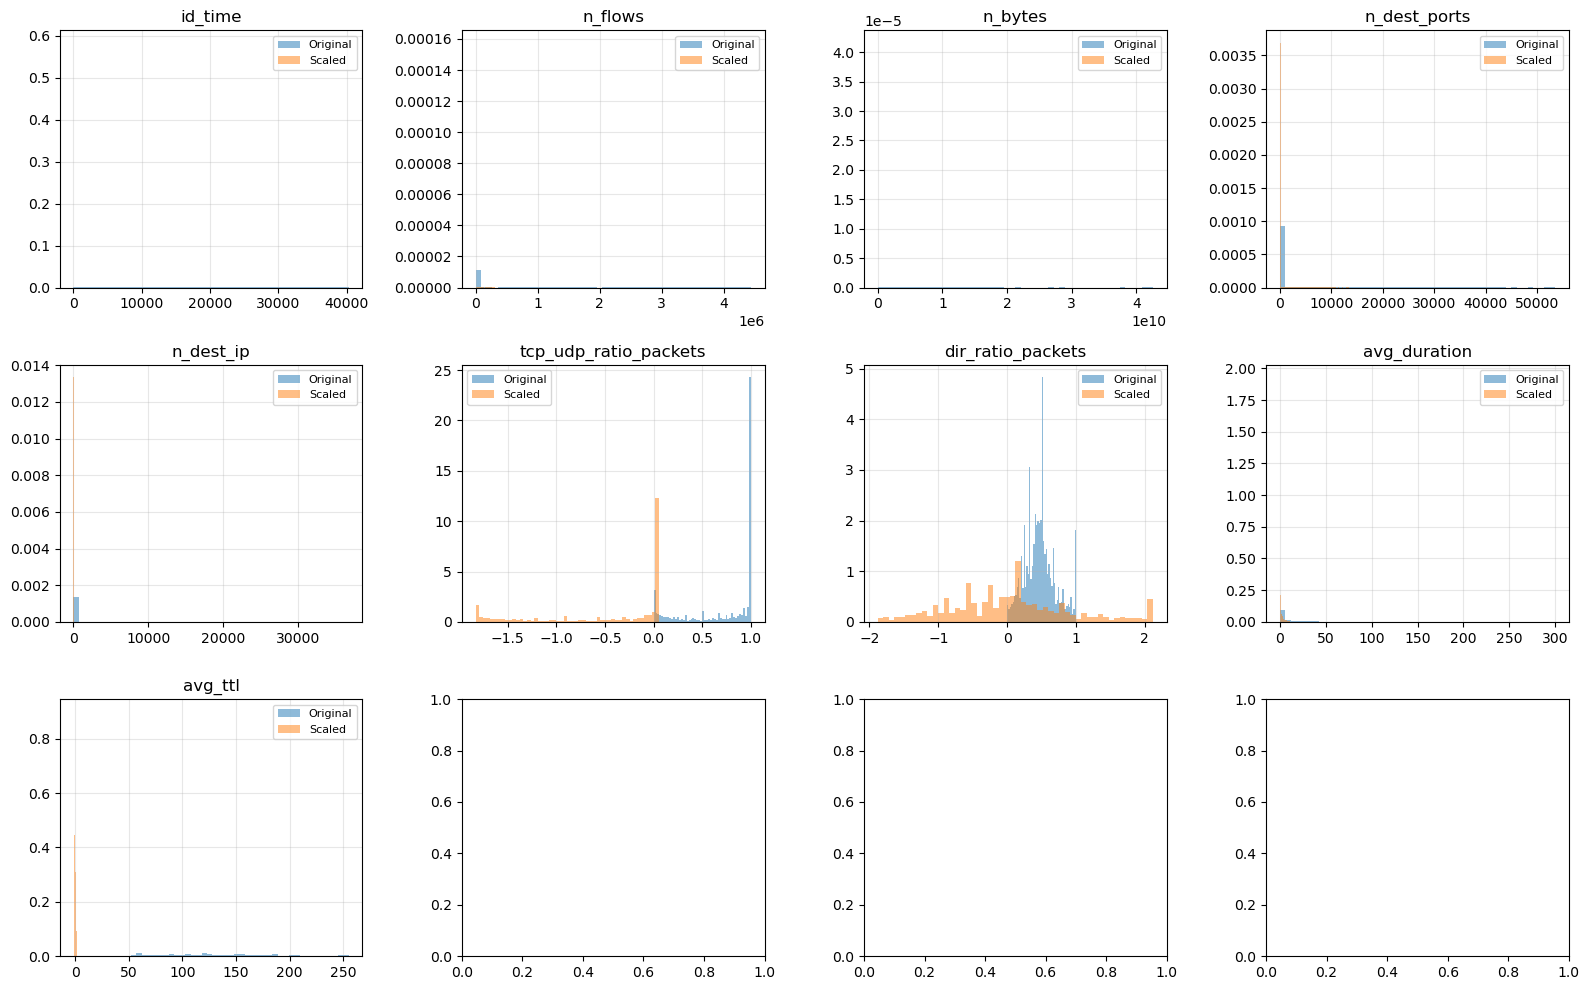

In [13]:
#visualizations

#distributions
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(features_to_keep):
    axes[idx].hist(x[col].values, bins=50, alpha=0.5, label='Original', density=True)
    axes[idx].hist(x_scaled_df[col].values, bins=50, alpha=0.5, label='Scaled', density=True)
    axes[idx].set_title(f'{col}')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

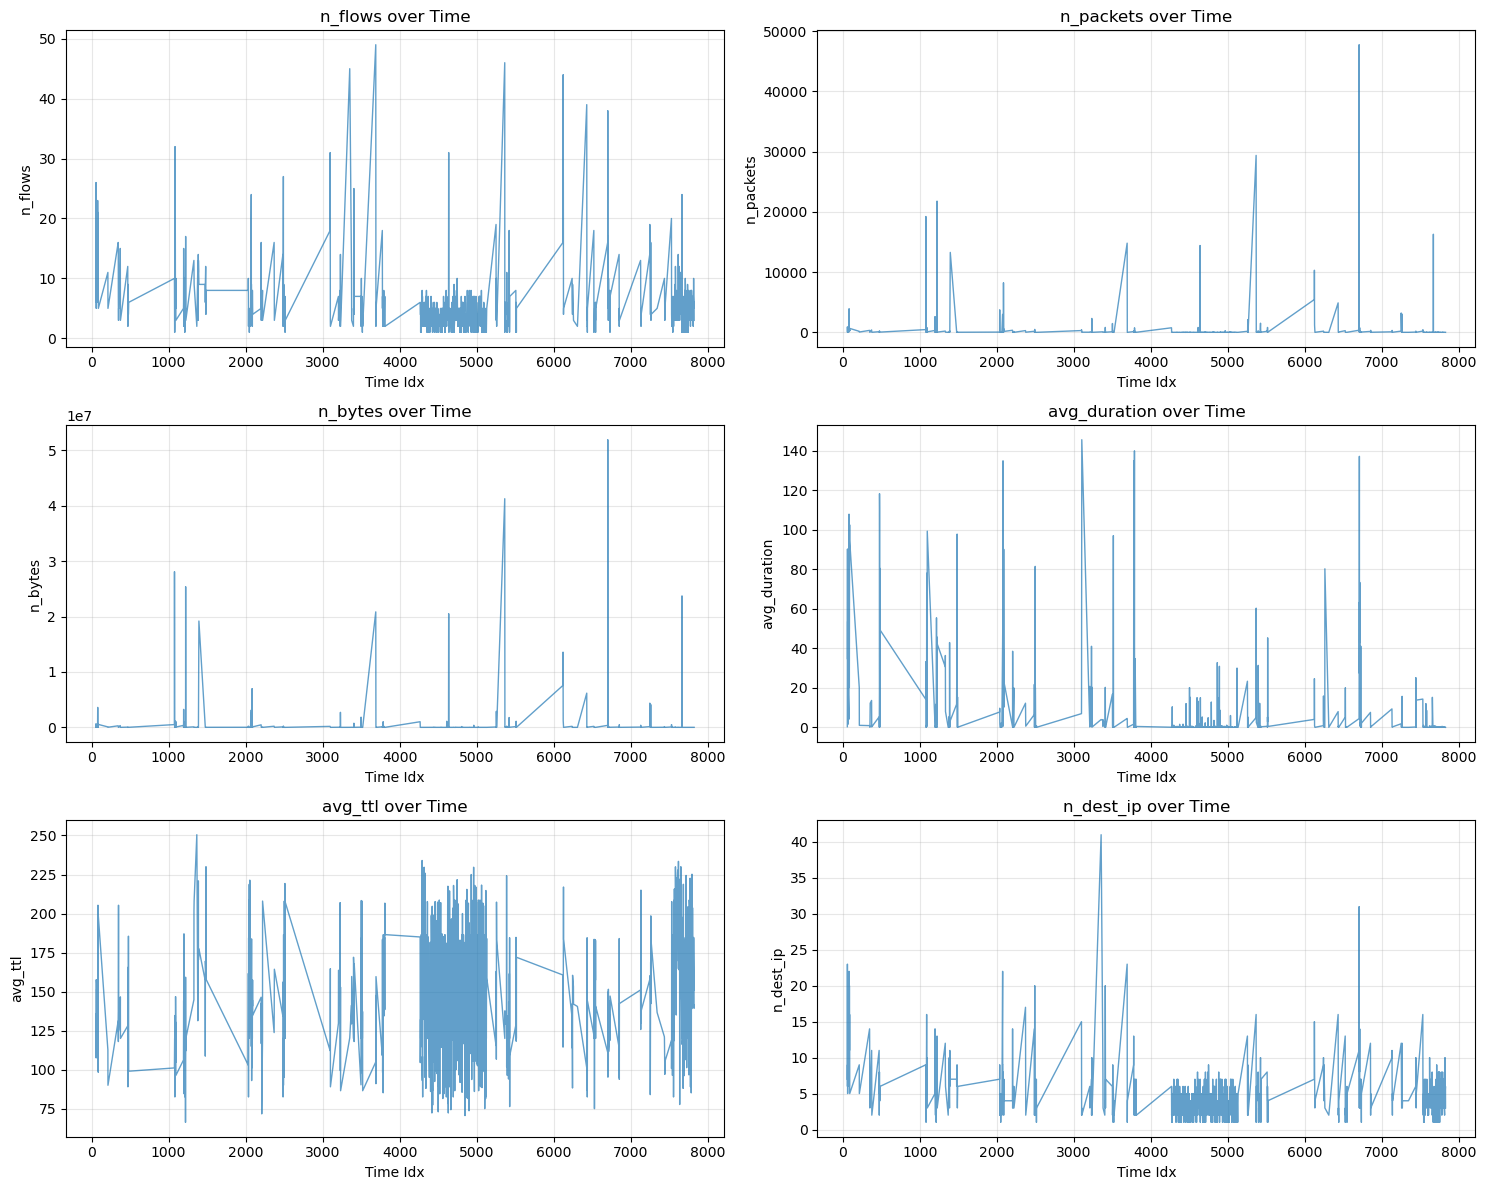

In [ ]:
#time distribution visuals
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
key_metrics = ['n_flows', 'n_packets', 'n_bytes', 'avg_duration', 'avg_ttl', 'n_dest_ip']

for idx, metric in enumerate(key_metrics):
    ax = axes[idx // 2, idx % 2]

    time_pts = df['id_time'].values[:1000]
    metric_vals = df[metric].values[:1000]

    ax.plot(time_pts, metric_vals, alpha=0.7, linewidth=1)
    ax.set_title(f'{metric} over Time')
    ax.set_xlabel('Time Idx')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
#saving data
preprocessed = {
    'X_original': x,
    'X_scaled': x_scaled_df,
    'features': features_to_keep,
    'scaler': scaler
}

x_scaled_df.to_csv('cesnet_preprocessed_scaled.csv', index=False)
x.to_csv('cesnet_preprocessed_original.csv', index=False)

2. Kmeans